# **Burn Severity Map of Tenerife wildfire, Aug 2023**

<hr>

## About

<img src='https://github.com/miguelvillasan/BurnSeverity-TenerifeFireAug2023/assets/112619698/0bd62cd9-9417-4b74-85bd-d3d90e415ba4' alt='Copernicus Sentinel-2' align='right' width='100%'></img>

<i>Source: https://www.copernicus.eu/en/media/image-day-gallery/evia-wildfire-greece</i>

### Notebook outline
- [1 - Load and browse the Sentinel-2 MSI data](#s2_load_21)
- [2 - Create natural colour composites](#s2_natural_21)
- [3 - Create false colour composites](#s2_false_21)
- [4 - Calculate the Normalized Burn Ratio (NBR) and Differenced NBR images](#s2_nbr_21)
- [5 - Create the burn severity map](#s2_burnseverity_21)

In [7]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install rasterio
#!pip install scikit-image
#!pip install sentinelsat
#!pip install geopandas

#### Load required libraries

In [1]:
#Python libraries

import os
import numpy as np
import pandas as pd
import glob as glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
from skimage import exposure
import rasterio
from rasterio import plot
from rasterio.plot import show

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

/Users/miguelvillasan/opt/anaconda3/envs/NBR_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr>

## <a id='s2_load_21'></a>1. Download the Sentinel-2 MSI data

In [9]:
#api = SentinelAPI('USER', 'PASS', 'https://scihub.copernicus.eu/dhus',show_progressbars=True)

In [10]:
## Search by polygon, time, and SciHub query keywords
#footprint = geojson_to_wkt(read_geojson('./TenerifeWildfire.geojson'))
#products = api.query(footprint,
#                     date=("20230814","20230825"),
#                     platformname='Sentinel-2',
#                     producttype= 'S2MSI2A')
#                     #cloudcoverpercentage=(0, 50))

In [11]:
## download all results from the search
#api.download_all(products)
#
## convert to Pandas DataFrame
#products_df = api.to_dataframe(products)
#
## GeoJSON FeatureCollection containing footprints and metadata of the scenes
#api.to_geojson(products)
#
## GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
#api.to_geodataframe(products)
#
## Get basic information about the product: its title, file size, MD5 sum, date, footprint and
## its download url
##api.get_product_odata(<product_id>)
#
## Get the product's full metadata available on the server
##api.get_product_odata(<product_id>, full=True)

In [12]:
#products_df = api.to_dataframe(products)
#products_df.head()

## <a id='s2_natural_21'></a>2. Create natural colour composites

### Natural colour composite from 13 August 2023

In [4]:
os.listdir('./SENTINEL_Images/PreFire_Images')

['T28RCS_20230813T115229_SCL_20m.jp2',
 'T28RCS_20230813T115229_B02_10m.jp2',
 'T28RCS_20230813T115229_B03_10m.jp2',
 'T28RCS_20230813T115229_B02_20m.jp2',
 'T28RCS_20230813T115229_B12_20m.jp2',
 'T28RCS_20230813T115229_B04_10m.jp2',
 'T28RCS_20230813T115229_B8A_20m.jp2']

In [5]:
aug_r10 = './SENTINEL_Images/PreFire_Images/'

band2=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B02_10m.jp2')
band3=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B03_10m.jp2')
band4=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B04_10m.jp2')

In [6]:
meta = band2.meta
meta.update({"count": 3})

In [7]:
prefire_rgb_path = './SENTINEL_Images/PreFire_Images/2023-08-13_S2_RGB.tif'

with rasterio.open(prefire_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

In [8]:
img = rasterio.open(prefire_rgb_path)

In [9]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 10980, 10980)

In [10]:
image = image.transpose(1,2,0)

In [11]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

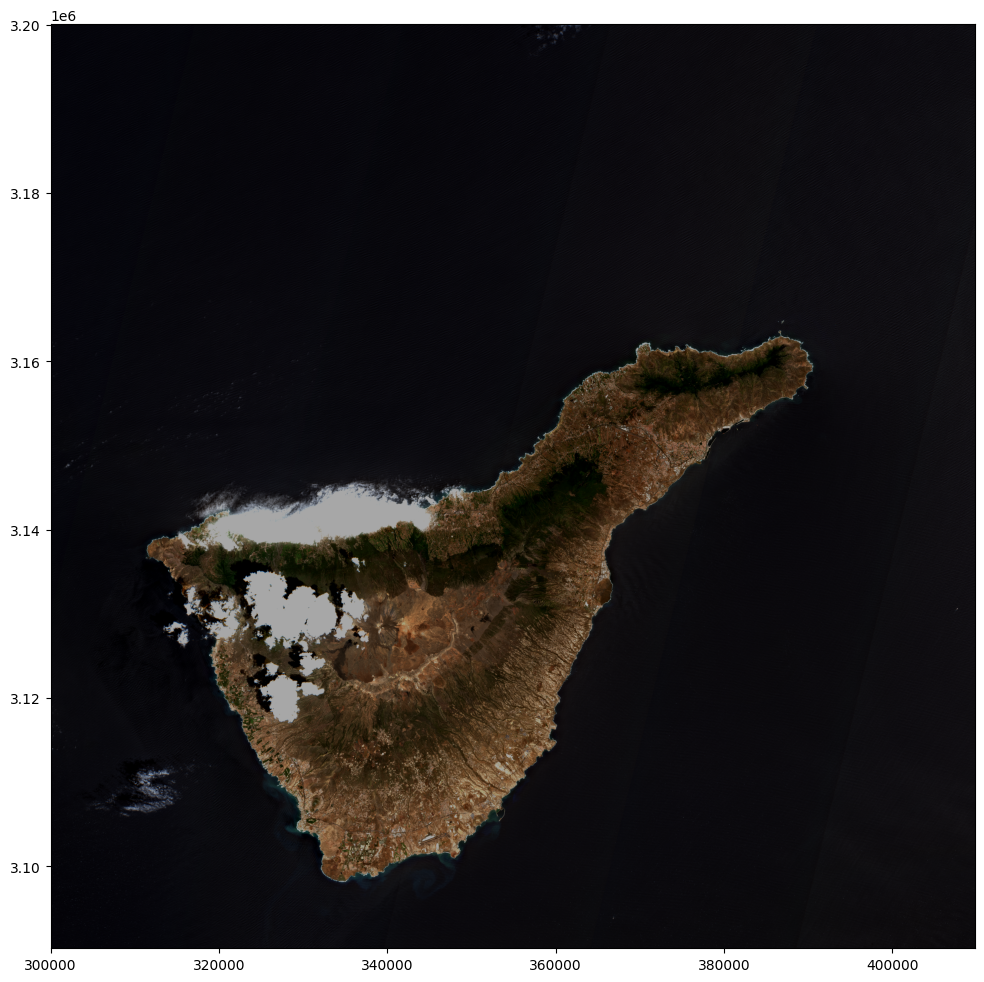

In [12]:
# Define a plot 2,98
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform);

### Natural colour composite from 7 September 2023

In [16]:
os.listdir('./SENTINEL_Images/PostFire_Images')

['T28RCS_20230907T115221_B02_20m.jp2',
 'T28RCS_20230907T115221_B12_20m.jp2',
 'T28RCS_20230907T115221_SCL_20m.jp2',
 'T28RCS_20230907T115221_B02_10m.jp2',
 'T28RCS_20230907T115221_B03_10m.jp2',
 'T28RCS_20230907T115221_B8A_20m.jp2',
 'T28RCS_20230907T115221_B04_10m.jp2']

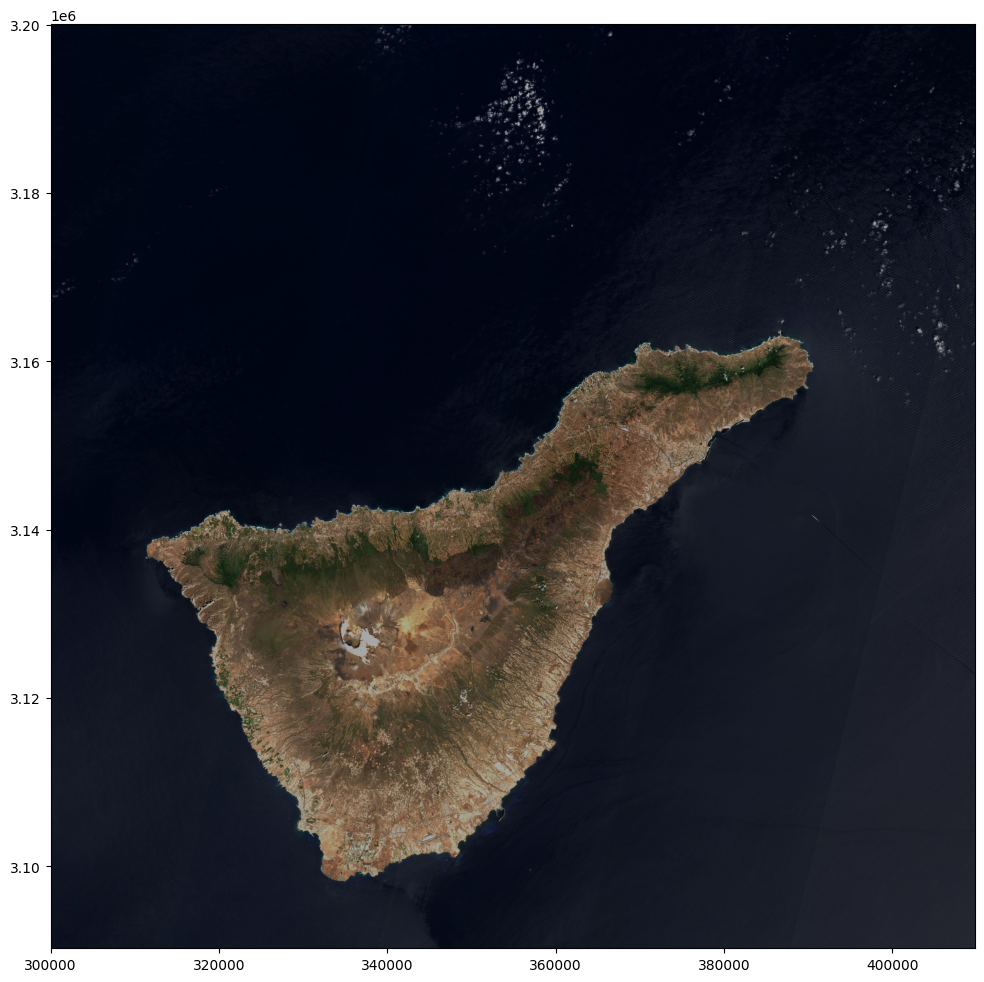

In [19]:
#Define the folder path where the images are stored
sept_r10 = './SENTINEL_Images/PostFire_Images/'

# Open b2, b3 and b4
band2=rasterio.open(sept_r10 + 'T28RCS_20230907T115221_B02_10m.jp2')
band3=rasterio.open(sept_r10 + 'T28RCS_20230907T115221_B03_10m.jp2')
band4=rasterio.open(sept_r10 + 'T28RCS_20230907T115221_B04_10m.jp2')

# Extract and update the metadata
meta = band2.meta
meta.update({"count": 3})

# Write the natural colour composite image with metadata
postfire_rgb_path = './SENTINEL_Images/PostFire_Images/2023-09-07_S2_RGB.tif'

with rasterio.open(postfire_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

# Transpose and rescale the image 
img = rasterio.open(postfire_rgb_path)
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (1,99))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image.transpose(2,0,1), transform=img.transform);

## <a id='s2_false_21'></a>3. Create false colour composites

### False colour composite from 13 August 2023

In [20]:
os.listdir('./SENTINEL_Images/PreFire_Images')

['T28RCS_20230813T115229_SCL_20m.jp2',
 'T28RCS_20230813T115229_B02_10m.jp2',
 'T28RCS_20230813T115229_B03_10m.jp2',
 'T28RCS_20230813T115229_B02_20m.jp2',
 'T28RCS_20230813T115229_B12_20m.jp2',
 '2023-08-13_S2_RGB.tif',
 'T28RCS_20230813T115229_B04_10m.jp2',
 '2023-08-13_S2_RGB.tif.aux.xml',
 'T28RCS_20230813T115229_B8A_20m.jp2']

In [21]:
aug_r20 = './SENTINEL_Images/PreFire_Images/'

band12=rasterio.open(aug_r20 + 'T28RCS_20230813T115229_B12_20m.jp2')
band8a=rasterio.open(aug_r20 + 'T28RCS_20230813T115229_B8A_20m.jp2')
band2=rasterio.open(aug_r20 + 'T28RCS_20230813T115229_B02_20m.jp2')

In [22]:
meta = band2.meta
meta.update({"count": 3})

In [23]:

prefire_false_rgb_path = './SENTINEL_Images/PreFire_Images/2023-08-13_S2_burnscar_RGB.tif'

with rasterio.open(prefire_false_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band8a.read(1),2)
    dest.write(band12.read(1),3)

In [24]:
img = rasterio.open(prefire_false_rgb_path)

In [25]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 5490, 5490)

In [26]:
image = image.transpose(1,2,0)

In [27]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

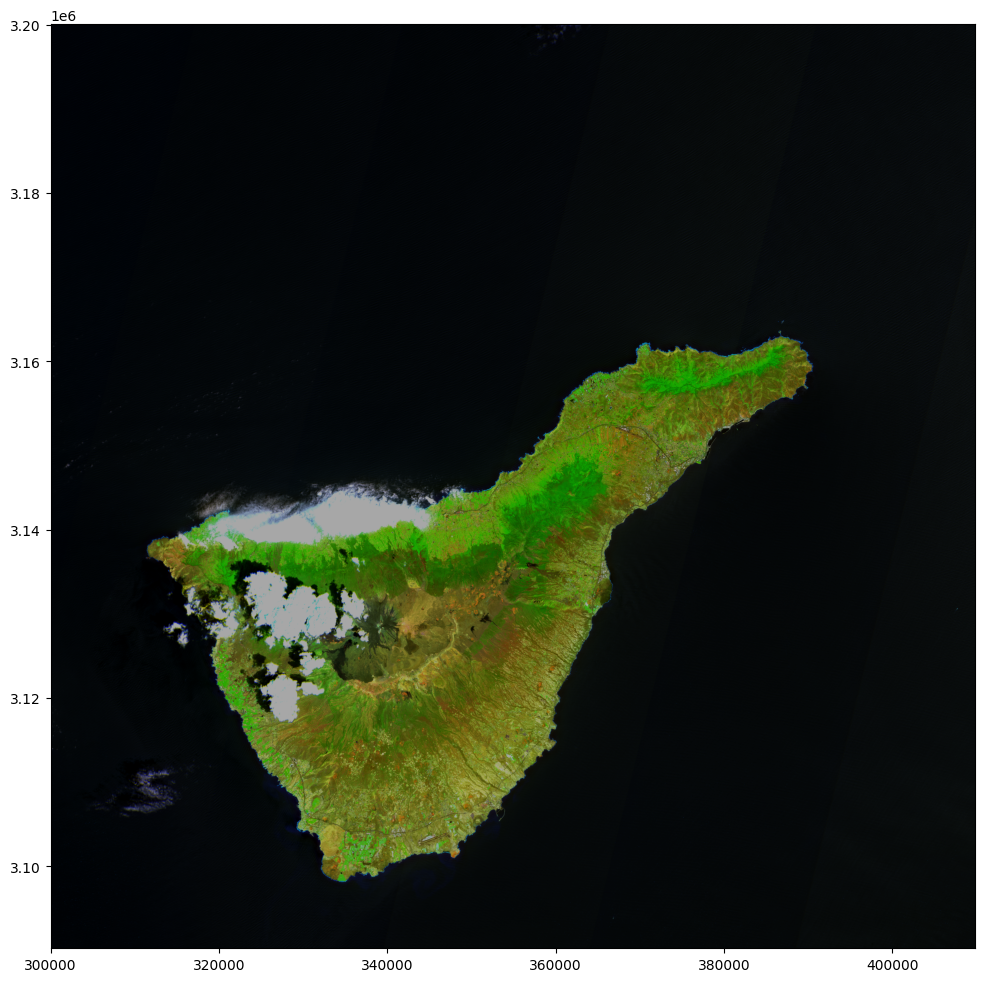

In [28]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform);

### False colour composite from 7 September 2023

In [29]:
os.listdir('./SENTINEL_Images/PostFire_Images')

['T28RCS_20230907T115221_B02_20m.jp2',
 'T28RCS_20230907T115221_B12_20m.jp2',
 '2023-09-07_S2_RGB.tif',
 'T28RCS_20230907T115221_SCL_20m.jp2',
 'T28RCS_20230907T115221_B02_10m.jp2',
 'T28RCS_20230907T115221_B03_10m.jp2',
 '2023-09-07_S2_RGB.tif.aux.xml',
 'T28RCS_20230907T115221_B8A_20m.jp2',
 'T28RCS_20230907T115221_B04_10m.jp2']

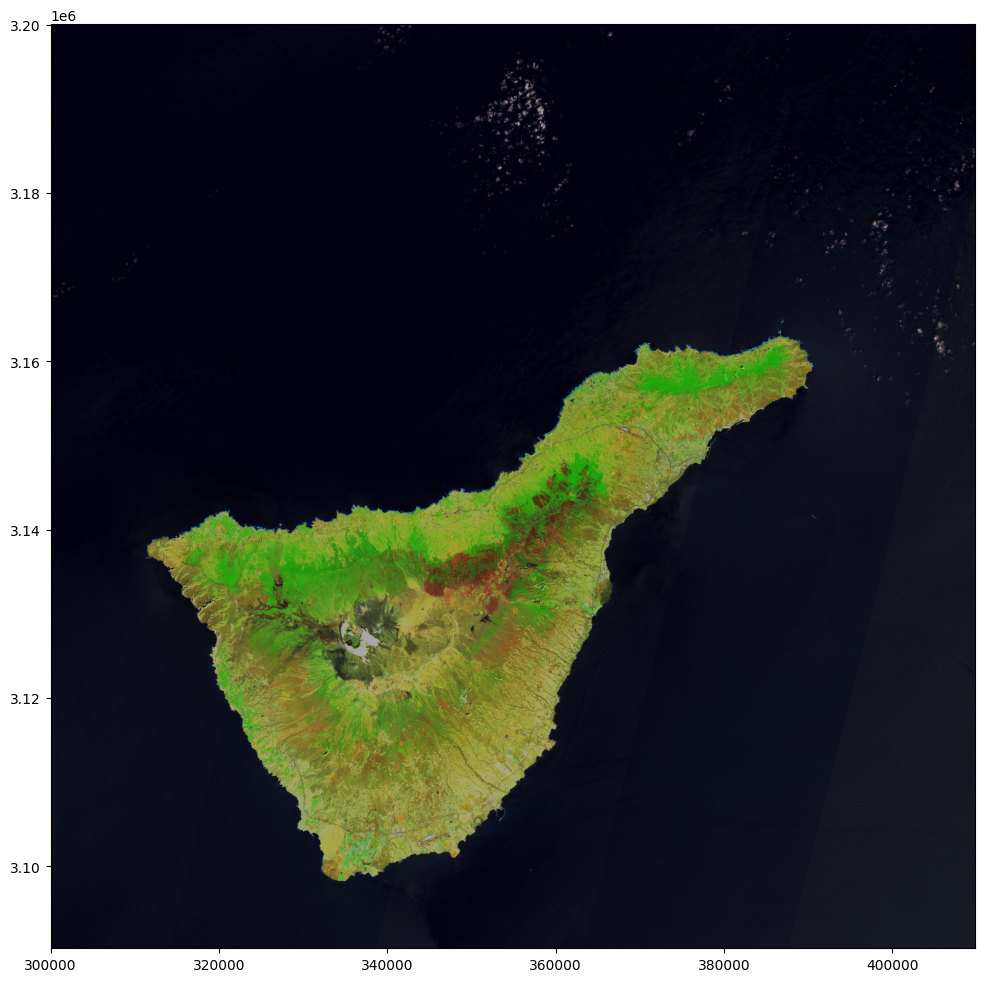

In [30]:
#Define the folder path where the images are stored
sept_r20 = './SENTINEL_Images/PostFire_Images/'

# Open b2, b8a and b12
band12=rasterio.open(sept_r20 + 'T28RCS_20230907T115221_B12_20m.jp2')
band8a=rasterio.open(sept_r20 + 'T28RCS_20230907T115221_B8A_20m.jp2')
band2=rasterio.open(sept_r20 + 'T28RCS_20230907T115221_B02_20m.jp2')

# Extract and update the metadata
meta = band2.meta
meta.update({"count": 3})

# Write the false colour composite image with metadata
postfire_false_rgb_path = './SENTINEL_Images/PostFire_Images/2023-09-07_S2_burnscar_RGB.tif'

with rasterio.open(postfire_false_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band8a.read(1),2)
    dest.write(band12.read(1),3)

# Transpose and rescale the image 
img = rasterio.open(postfire_false_rgb_path)
image = np.array([img.read(3), img.read(2), img.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image.transpose(2,0,1), transform=img.transform);

## <a id='s2_nbr_21'></a>4. Calculate the Normalized Burn Ratio (NBR) and Differenced NBR images

As explained by [UN SPIDER](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/burn-severity-earth-engine), the Normalized Burn Ratio “uses near-infrared (NIR) and shortwave-infrared (SWIR) wavelengths. Healthy vegetation before the fire has very high NIR reflectance and a low SWIR response. In contrast, recently burned areas have a low reflectance in the NIR and high reflectance in the SWIR band.” The formula is `NBR = (NIR - SWIR) / (NIR + SWIR)` or using the MSI band numbers: `NBR = (B8A - B12) / (B8A + B12)`. 

### NBR on 13 August 2023 (pre-fire)

In [43]:
os.listdir('./SENTINEL_Images/PreFire_Images')

['T28RCS_20230813T115229_SCL_20m.jp2',
 'T28RCS_20230813T115229_B02_10m.jp2',
 'T28RCS_20230813T115229_B03_10m.jp2',
 '2023-08-13_S2_burnscar_RGB.tif.aux.xml',
 'T28RCS_20230813T115229_B02_20m.jp2',
 'T28RCS_20230813T115229_B12_20m.jp2',
 '2023-08-13_S2_NBR.tif',
 '2023-08-13_S2_RGB.tif',
 'T28RCS_20230813T115229_B04_10m.jp2',
 '2023-08-13_S2_burnscar_RGB.tif',
 '2023-08-13_S2_RGB.tif.aux.xml',
 'T28RCS_20230813T115229_B8A_20m.jp2']

In [44]:
b8a=rasterio.open(aug_r20 + 'T28RCS_20230813T115229_B8A_20m.jp2')
b12=rasterio.open(aug_r20 + 'T28RCS_20230813T115229_B12_20m.jp2')

In [33]:
swir = b12.read()
nir = b8a.read()

In [34]:
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

In [35]:
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

In [36]:
prefire_nbr_path = './SENTINEL_Images/PreFire_Images/2023-08-13_S2_NBR.tif'

with rasterio.open(prefire_nbr_path, 'w', **meta) as dest:
    dest.write(nbr.astype(rasterio.float32))

In [37]:
img = rasterio.open(prefire_nbr_path)
img_r = img.read()
image = np.asarray(img_r)

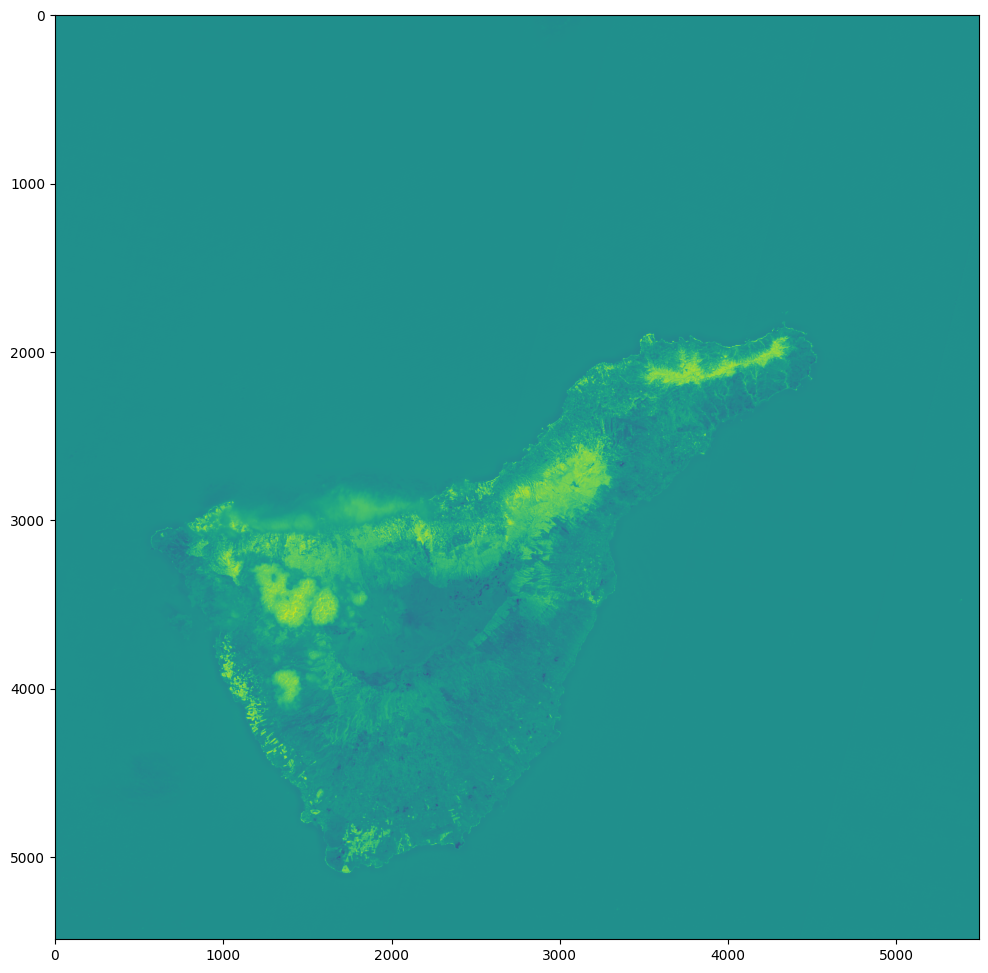

In [38]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image);

### NBR on 7 September 2023 (post-fire)

In [45]:
os.listdir('./SENTINEL_Images/PostFire_Images')

['T28RCS_20230907T115221_B02_20m.jp2',
 'T28RCS_20230907T115221_B12_20m.jp2',
 '2023-09-07_S2_RGB.tif',
 '2023-09-09_S2_NBR.tif',
 'T28RCS_20230907T115221_SCL_20m.jp2',
 'T28RCS_20230907T115221_B02_10m.jp2',
 'T28RCS_20230907T115221_B03_10m.jp2',
 '2023-09-07_S2_RGB.tif.aux.xml',
 '2023-09-07_S2_burnscar_RGB.tif',
 '2023-09-07_S2_burnscar_RGB.tif.aux.xml',
 'T28RCS_20230907T115221_B8A_20m.jp2',
 'T28RCS_20230907T115221_B04_10m.jp2']

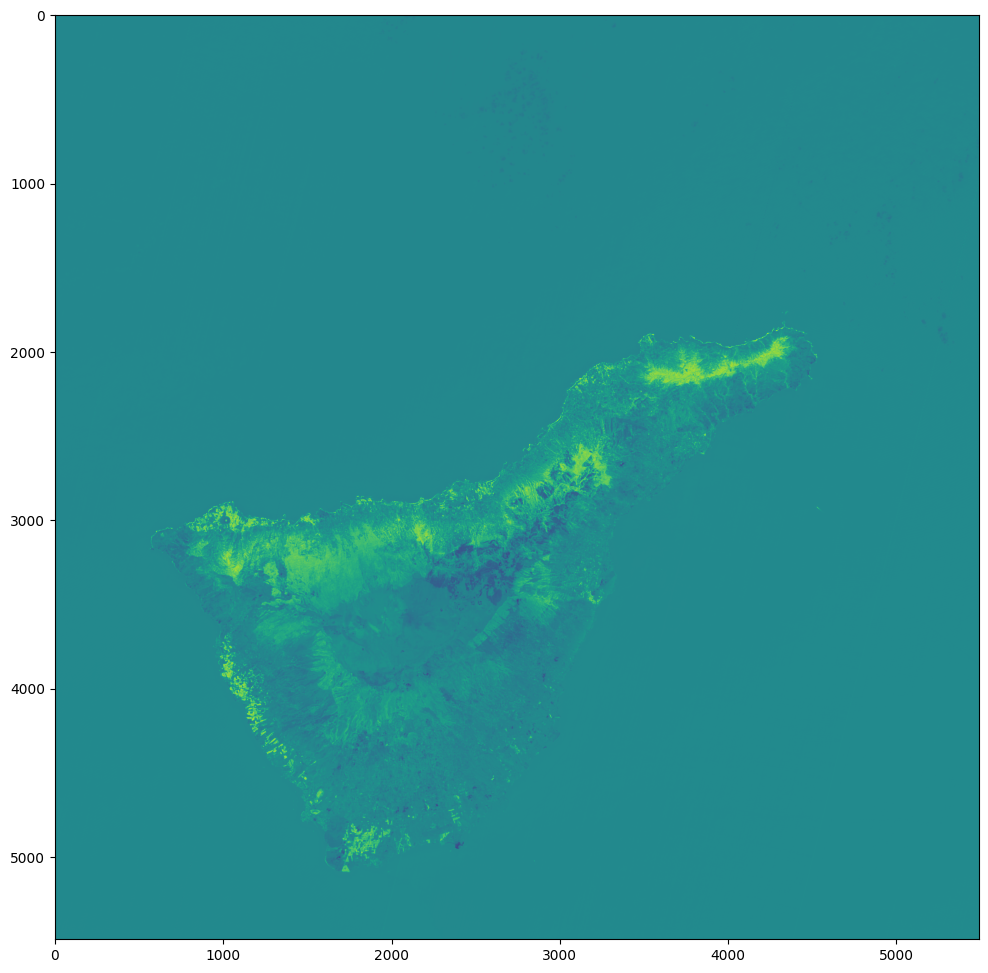

In [40]:
# Open b8a and b12
b8a=rasterio.open(sept_r20 + 'T28RCS_20230907T115221_B8A_20m.jp2')
b12=rasterio.open(sept_r20 +'T28RCS_20230907T115221_B12_20m.jp2')

# read NIR(b8a) and SWIR(b12) as arrays
swir = b12.read()
nir = b8a.read()

# Calculate NBR
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

# Extract and update the metadata
meta = b12.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

# Write the NBR image with metadata
postfire_nbr_path = './SENTINEL_Images/PostFire_Images/2023-09-09_S2_NBR.tif'

with rasterio.open(postfire_nbr_path, 'w', **meta) as dest:
    dest.write(nbr.astype(rasterio.float32))
    
# Open and read the image
img = rasterio.open(postfire_nbr_path)
img_r = img.read()
image = np.asarray(img_r)

# Plot the resulting image
fig = plt.figure(figsize=(20,12))
show(image);

### Differenced NBR (pre-fire minus post-fire NBR)

In [41]:
# Open NBR images from 13 August 2023 (pre-fire) and 23 August 2023 (post-fire)
pre_nbr = rasterio.open(prefire_nbr_path)
post_nbr = rasterio.open(postfire_nbr_path)

# Read the images in as arrays
pre = pre_nbr.read()
post = post_nbr.read()

In [42]:
dnbr = pre.astype(rasterio.float32)-post.astype(rasterio.float32)

In [46]:
meta = pre_nbr.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

In [47]:
dnbr_path = './SENTINEL_Images/2023-08-13_sub_2023-09-07_S2_dNBR.tif'

with rasterio.open(dnbr_path, 'w', **meta) as dest:
    dest.write(dnbr.astype(rasterio.float32))

In [48]:
# Rescale the image
img = rasterio.open(dnbr_path)
img_r = img.read()
image = np.asarray(img_r)

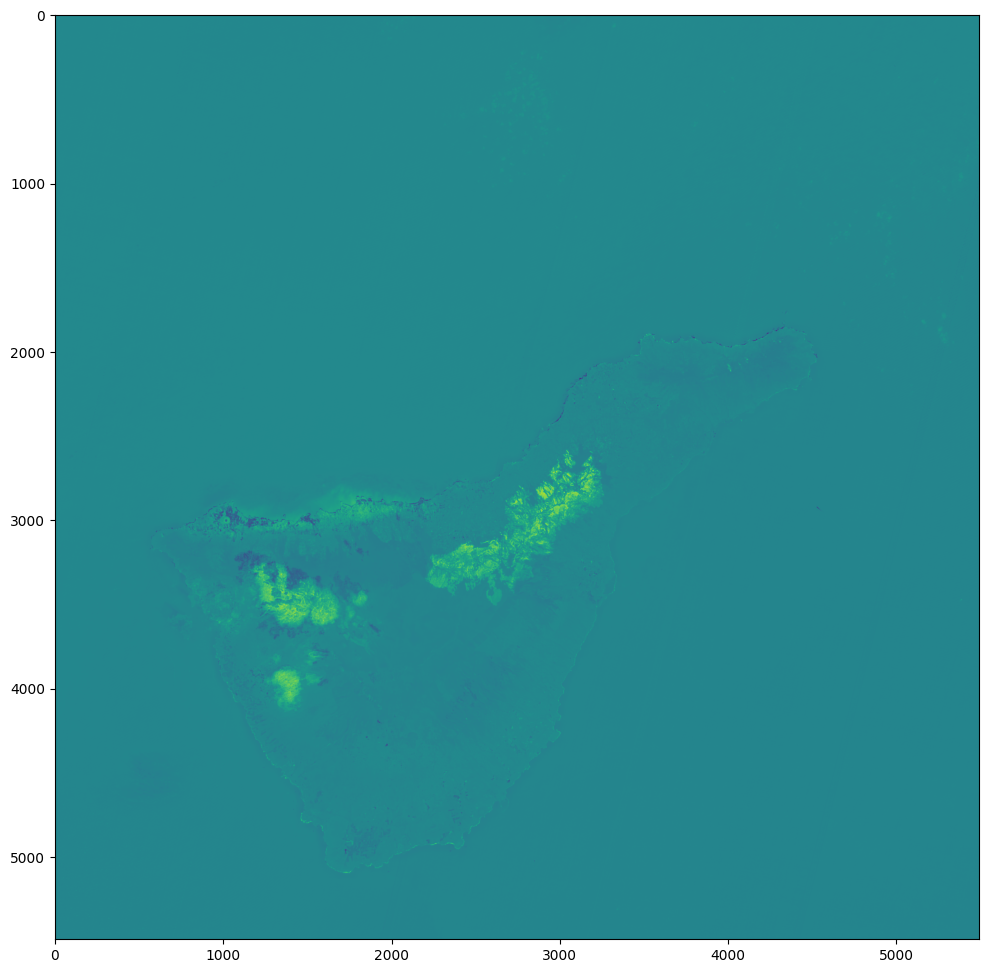

In [49]:
fig = plt.figure(figsize=(20,12))
show(image);

## <a id='s2_burnseverity_21'></a>5. Create the burn severity map

### Create water mask using Scene Classification Layer (20m resolution)

In [52]:
scl_image = rasterio.open('./SENTINEL_Images/PostFire_Images/T28RCS_20230907T115221_SCL_20m.jp2')

In [53]:
scl = scl_image.read()
scl = np.array(scl)
scl

array([[[6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]]], dtype=uint8)

In [54]:
water = np.where(scl != 6, np.nan, scl)
water

array([[[6., 6., 6., ..., 6., 6., 6.],
        [6., 6., 6., ..., 6., 6., 6.],
        [6., 6., 6., ..., 6., 6., 6.],
        ...,
        [6., 6., 6., ..., 6., 6., 6.],
        [6., 6., 6., ..., 6., 6., 6.],
        [6., 6., 6., ..., 6., 6., 6.]]])

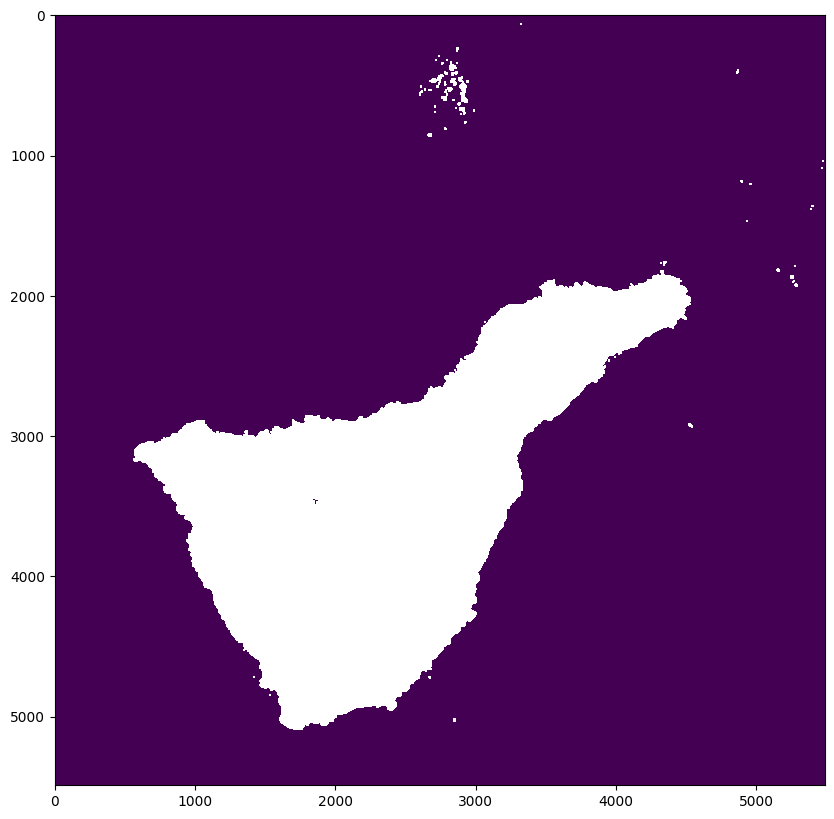

<Axes: >

In [55]:
fig = plt.figure(figsize=(10,10))
show(water)

In [56]:
meta = scl_image.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float32)

In [57]:
water_path = './SENTINEL_Images/2023-09-07_S2_water.tif'

with rasterio.open(water_path, 'w', **meta) as dest:
    dest.write(water.astype(rasterio.float32))

### Classify the dNBR raster using the burn severity classification table

In [58]:
img = rasterio.open(dnbr_path)
img_r = img.read(1)
image = np.asarray(img_r)*1000

In [59]:
water_img = rasterio.open(water_path)
water_r = water_img.read(1)
water = np.asarray(water_r)

In [60]:
#set colours for plotting and classes
cmap = ListedColormap([[122/255., 135/255., 55/255.],
                          [172/255., 190/255., 77/255.],
                          [10/255., 224/255., 66/255.],
                          [255/255., 247/255., 11/255.],
                          [255/255., 175/255., 56/255.],
                          [255/255., 100/255., 27/255.],
                          [164/255., 31/255., 214/255.],
                          [255/255., 255/255., 255/255.]])

In [61]:
bounds = [-1000, -251, -101, 99, 269, 439, 659, 1300, 2000]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)  

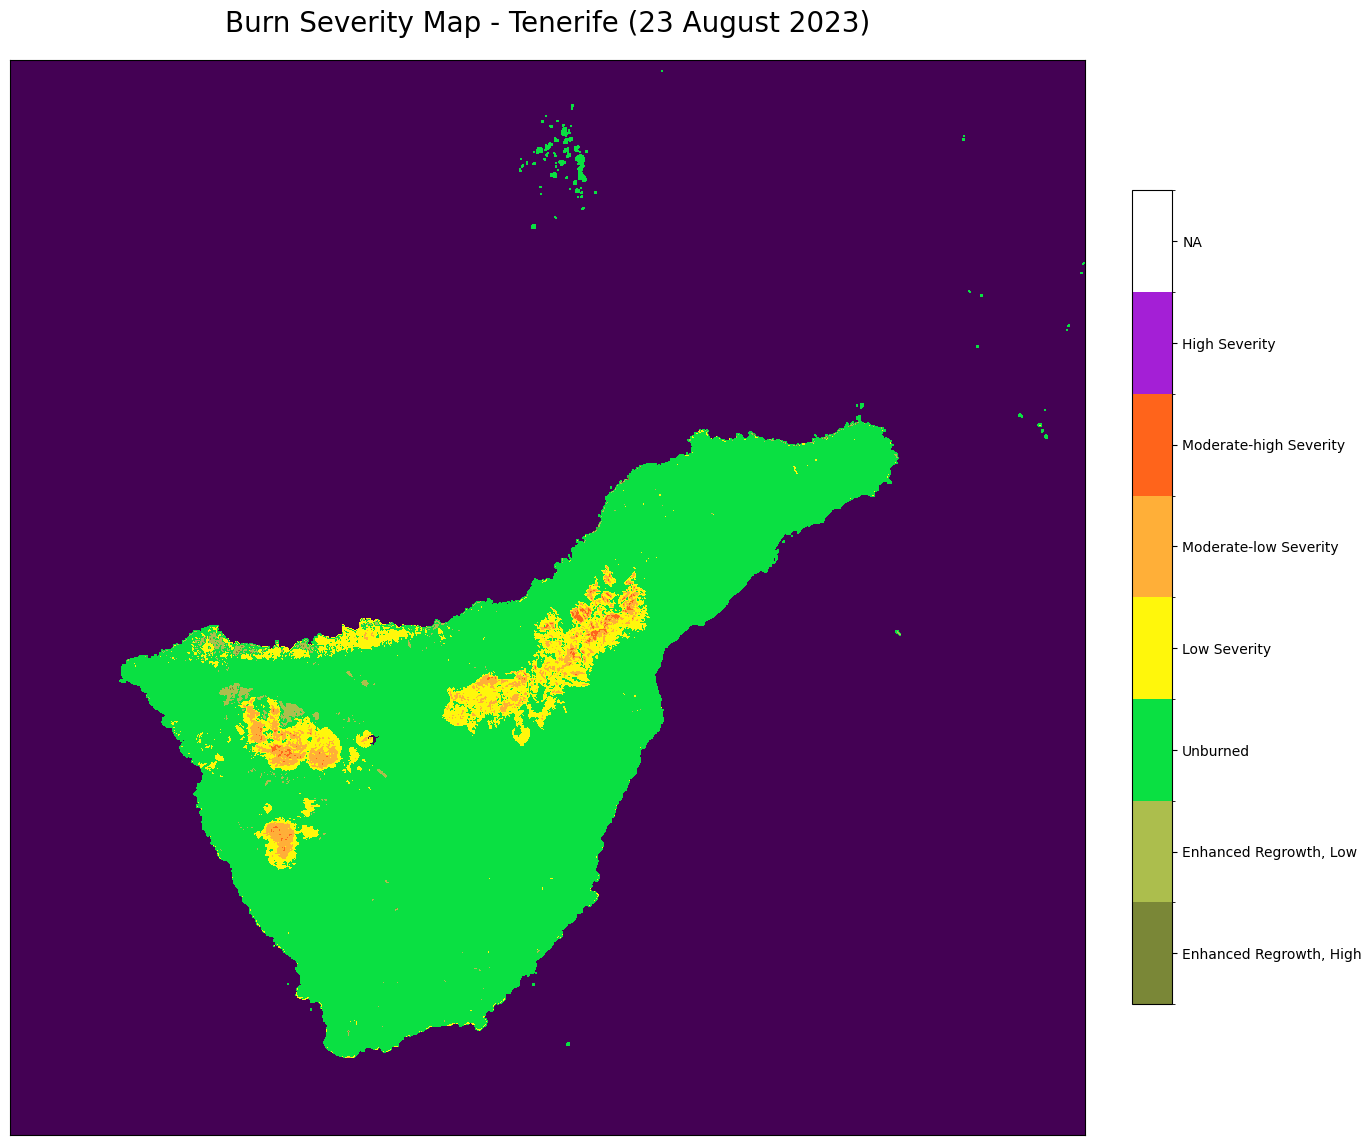

In [62]:
# Define the figure
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

# Use `.imshow()` to plot the dNBR image with the custom colormap and norm
cax = ax.imshow(image, cmap=cmap, norm = norm)

# Add the water mask image to the figure using `.imshow()`
ax.imshow(water)

# Add a figure title
plt.title('Burn Severity Map - Tenerife (23 August 2023)', fontsize=20, pad=20.0)

# Add a colorbar 
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=[-625, -176, -1, 184, 354, 549, 980, 1650])

# Set the tick labels to reflect the burn severity classes
cbar.ax.set_yticklabels(['Enhanced Regrowth, High',
         'Enhanced Regrowth, Low',
         'Unburned', 
         'Low Severity', 
         'Moderate-low Severity', 
         'Moderate-high Severity', 
         'High Severity', 
         'NA'])

# Show the plot
plt.show();

In [ ]:
#NEXT STEPS:
#Restringir el tamaño de la imagen al área del incendio
#Esperar a la puesta en línea de la imagen de antes del incendio 
#Crear imágenes del incendio activo y sacar las de falso color
#Generar textos explicativos
#Tunear la parte de descarga por API
